In [361]:
import pandas as pd
import numpy as np
from os import listdir
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import librosa
from librosa import load
import librosa.display
from librosa.feature import melspectrogram
from librosa.feature import mfcc

# SETTINGS
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# CONSTS
PATH = './data/'
PATH_TRAIN = PATH + 'train_wavs/'
PATH_TEST = PATH + 'test_wavs/'

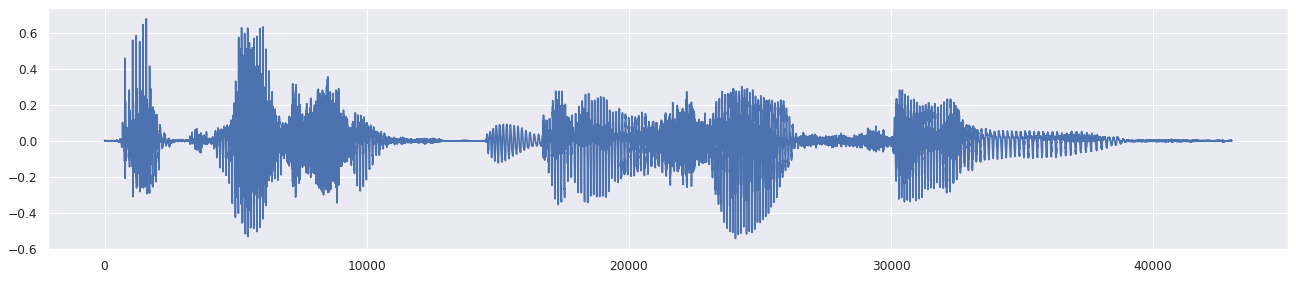

In [362]:
# Look at some signal
filename = listdir(PATH_TRAIN)[15]

signal, sample_rate = load(PATH_TRAIN + filename)
plt.figure(figsize=(20, 4), dpi=80)
plt.plot(signal)

## Preprocessing Pipeline
<p><ol>
    <li>
        <section>
        <h4>Pre-Emphasis:</h4>
        <ul>
            <li> Cбалансировать частотный спектр, т.к. высокие частоты обычно имеют меньшую амплитуду по сравнению с более низкими частотами </li> <li> Избежать числовых проблем во время операции преобразования Фурье </li> 
            <li > Может также улучшить качество сигнала  </li>
        </section>
        </ul>
    </li>
    <li>
        <section>
        <h4>Framing:</h4>
        <ul>
            <li> Частоты в сигнале меняются со временем, поэтому нет смысла выполнять преобразование Фурье для всего сигнала, т.к. мы потеряем частотные контуры сигнала с течением времени </li>
        </ul>
        </section>
    </li>
    <li>
        <section>
        <h4>Windowing:</h4>
        <ul>
            <li> После разделения сигнала на кадры мы применяем оконную функцию, такую как окно Хэмминга, к каждому фрейму </li>
        </ul>
        </section>
    </li>
    <li>
        <section>
        <h4>MFCC:</h4>
        <ul>
            <li> Его все юзают) </li>
        </ul>
        </section>
    </li>
</ol></p>

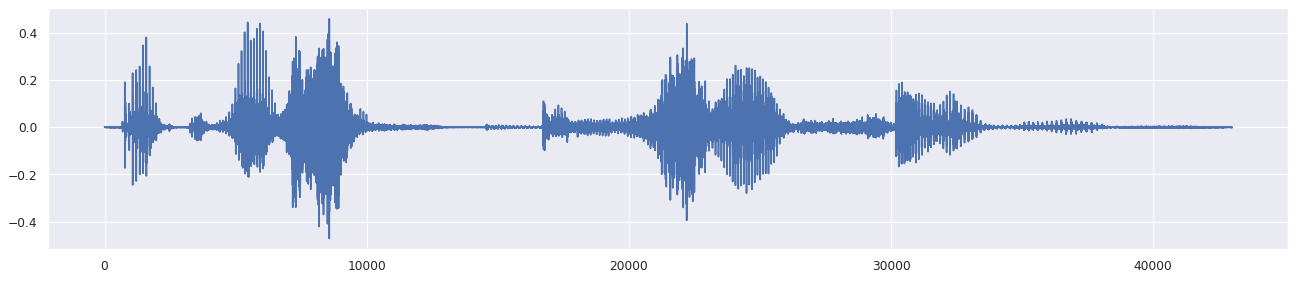

In [363]:
# Pre-Emphasis example
def pre_emphasising(signal, pre_emphasis=0.97):
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
    return emphasized_signal

emphasized_signal = pre_emphasising(signal)
plt.figure(figsize=(20, 4), dpi=80)
plt.plot(emphasized_signal)

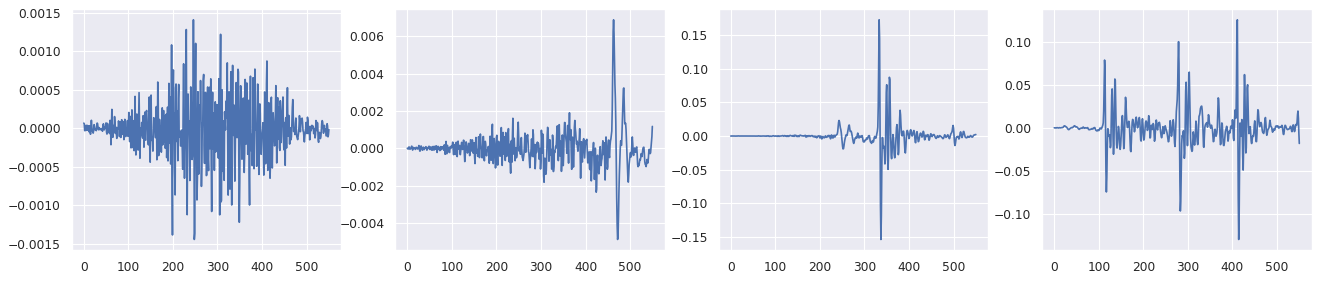

In [364]:
# Framing and Winowing example here
frame_size = 0.025
frame_stride = 0.01

def framing(emphasized_signal, frame_size=0.025, frame_stride=0.01, windowing=True):
    # frame_size и frame_stride в Милисекундах
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    if windowing:
        frames *= np.hamming(frame_length)
    return frames

frames = framing(emphasized_signal)

fig, axs = plt.subplots(1, 4, figsize=(20, 4), dpi=80)
for i in range(4):
    axs[i].plot(frames[i])

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=551
  warnings.warn(


[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

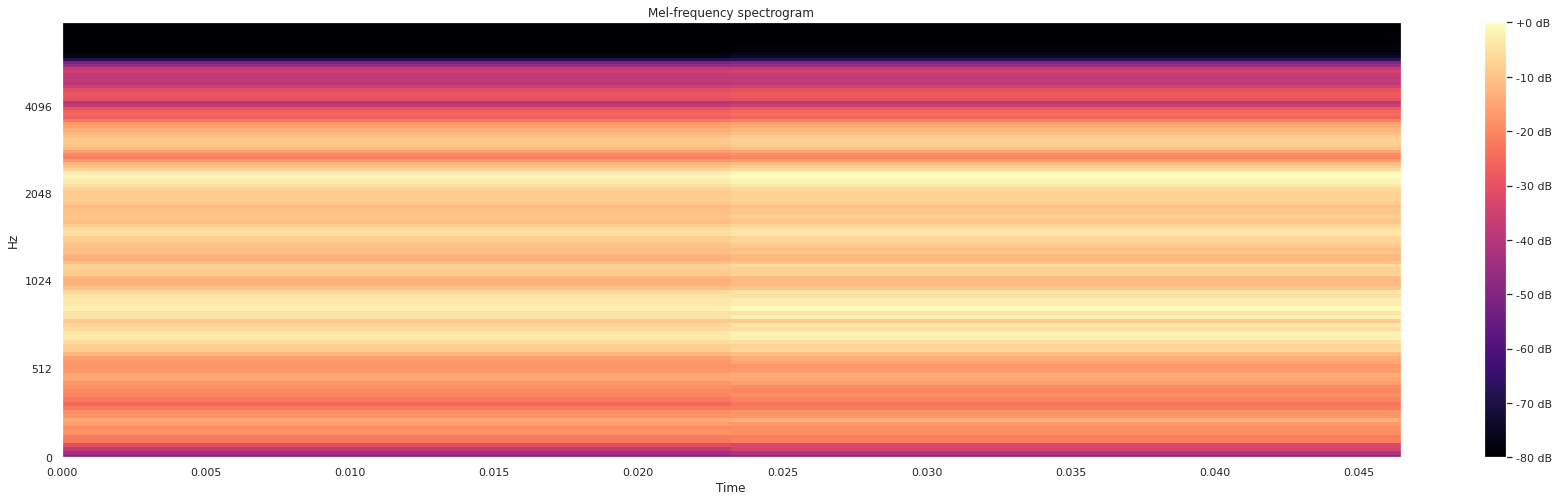

In [365]:
# Mel-Spectrogram
S = melspectrogram(frames[2])
fig, ax = plt.subplots()

S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sample_rate,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

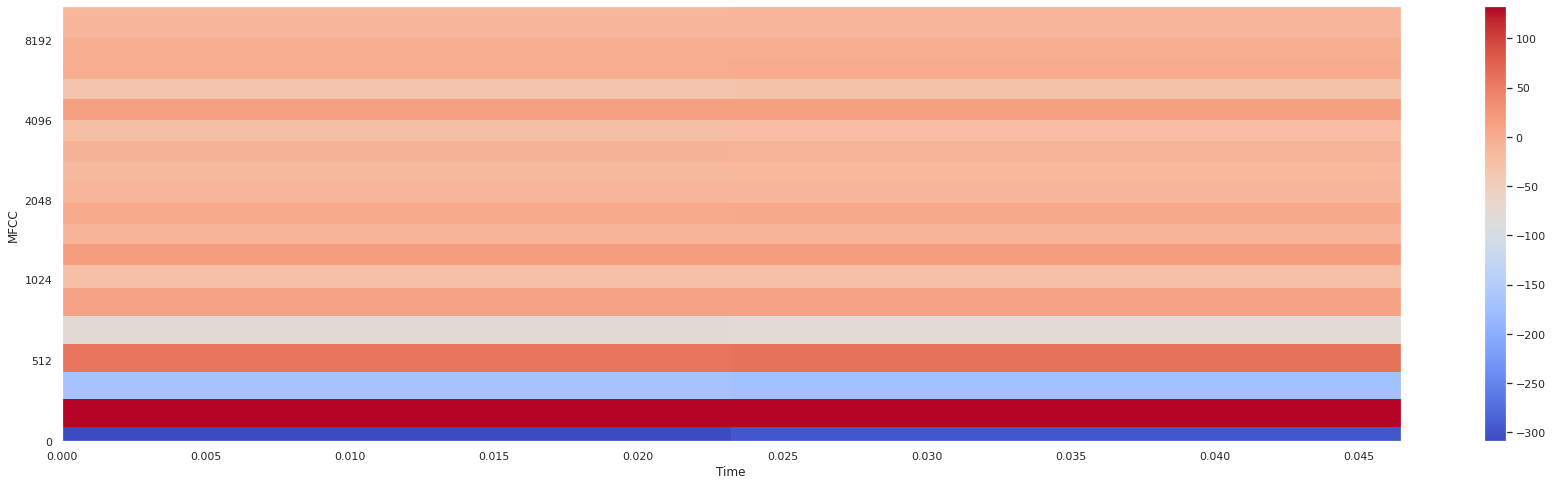

In [366]:
# MFCC
mfcc_data = mfcc(frames[2], sr=sample_rate)

librosa.display.specshow(mfcc_data, sr=sample_rate, x_axis='time', y_axis='mel')
plt.ylabel('MFCC')
plt.colorbar()

## Preprocessing Pipeline и Augmentations для исходного сигнала

In [367]:
class Augmentations:
    def white_noise(self, signal, min=-0.05, max=0.05):
        ''' Добавляем Белый шум к первой половине, второй половине и всему сигналу '''
        aug_signals = []

        noise = np.random.uniform(min, max, signal.shape[0] // 2)
        aug_signal = np.concatenate( (signal[:signal.shape[0] // 2] + noise, signal[signal.shape[0] // 2:]) )
        aug_signals.append( aug_signal )

        noise = np.random.uniform(min, max, signal.shape[0] - signal.shape[0] // 2)
        aug_signal = np.concatenate( (signal[:signal.shape[0] // 2], signal[signal.shape[0] // 2:] + noise) )
        aug_signals.append( aug_signal )

        noise = np.random.uniform(min, max, signal.shape[0])
        aug_signal = signal + noise
        aug_signals.append( aug_signal )

        return aug_signals

    def gaussian_nois(self, signal, mean=0, std=0.03):
        ''' Добавляем Нормальный шум к первой половине, второй половине и всему сигналу '''
        aug_signals = []

        noise = np.random.normal(mean, std, signal.shape[0] // 2)
        aug_signal = np.concatenate( (signal[:signal.shape[0] // 2] + noise, signal[signal.shape[0] // 2:]) )
        aug_signals.append( aug_signal )

        noise = np.random.normal(mean, std, signal.shape[0] - signal.shape[0] // 2)
        aug_signal = np.concatenate( (signal[:signal.shape[0] // 2], signal[signal.shape[0] // 2:] + noise) )
        aug_signals.append( aug_signal )

        noise = np.random.normal(mean, std, signal.shape[0])
        aug_signal = signal + noise
        aug_signals.append( aug_signal )

        return aug_signals

    def augmentation(self, signal):
        aug_signals = []
        aug_signals.extend(self.gaussian_nois(signal))
        aug_signals.extend(self.white_noise(signal))
        return aug_signals

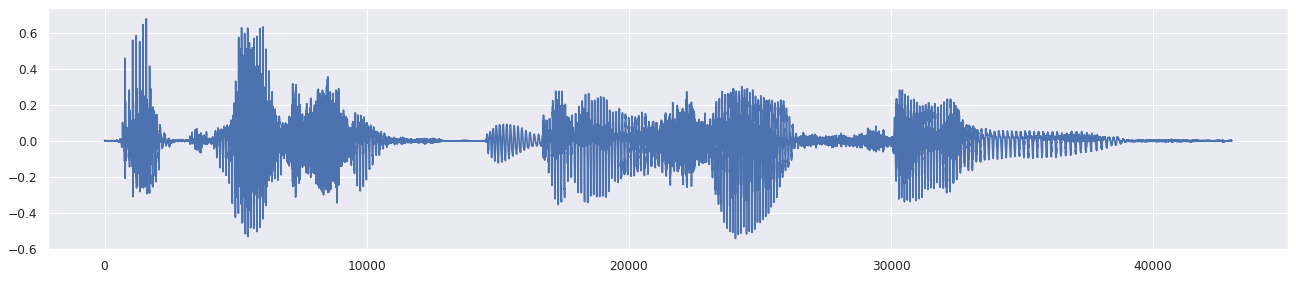

In [368]:
# Исходный Сигнал
plt.figure(figsize=(20, 4), dpi=80)
plt.plot(signal)

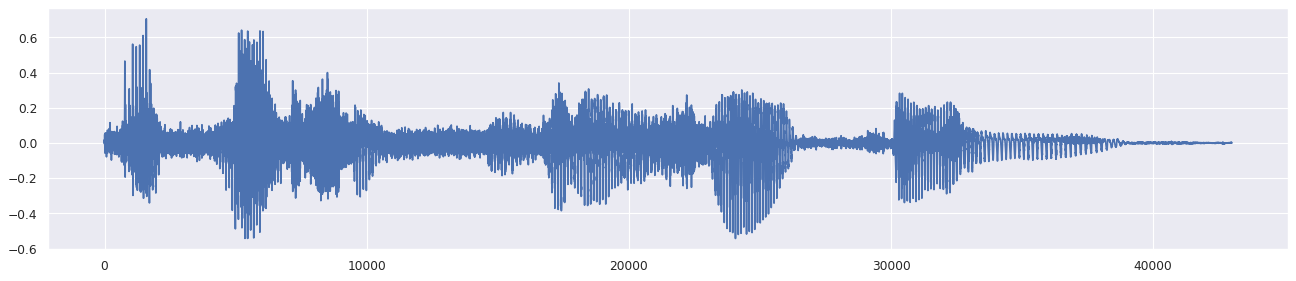

In [369]:
# Пример нормального шума для первой половины
aug = Augmentations()
aug_signals = aug.augmentation(signal)
plt.figure(figsize=(20, 4), dpi=80)
plt.plot(aug_signals[0])

In [370]:
class PreprocessingPipeline(Augmentations):
    def __init__(self, files_path=None, files_list=None):
        super().__init__()
        self.files = []
        if files_path is not None:
            self.files = [files_path + filename for filename in listdir(files_path)]
        if files_list is not None:
            self.files = files_list

        self.transforms = {
            'mfcc': mfcc,
            'melspectrogram': melspectrogram
        }

        self.data = []

    def pre_emphasising(self, signal, pre_emphasis=0.97):
        emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])
        return emphasized_signal
    
    def framing(self, emphasized_signal, frame_size=0.025, frame_stride=0.01, windowing=True):
        # frame_size и frame_stride в Милисекундах
        frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
        signal_length = len(emphasized_signal)
        frame_length = int(round(frame_length))
        frame_step = int(round(frame_step))
        num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

        pad_signal_length = num_frames * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        pad_signal = np.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames = pad_signal[indices.astype(np.int32, copy=False)]
        if windowing:
            frames *= np.hamming(frame_length)
        return frames
    
    def process(self, signal, sample_rate, tr_type):
        ''' Препроцессинг - применяет последовательно для каждого сигнала функции, описанные выше и считает MFCC '''
        emphasized_signal = self.pre_emphasising(signal)
        frames = self.framing(emphasized_signal)

        data_frames = []
        tr_method = self.transforms.get(tr_type)
        for frame in frames:
            mfcc_data = tr_method(frame, sr=sample_rate)
            data_frames.append(mfcc_data)
        self.data.append(np.array(data_frames))

    def transform(self, tr_type='mfcc', using_aug=True):
        ''' Функция для применения препроцессинга и аугментаций к каждому файлу '''
        for filename in self.files:
            signal, sample_rate = load(filename)

            signals = [signal]
            if using_aug:
                signals.extend(self.augmentation(signal))

            for signal in signals:
                self.process(signal, sample_rate, tr_type)

        return self.data

In [371]:
pipeline = PreprocessingPipeline(files_list=[PATH_TRAIN+listdir(PATH_TRAIN)[0], PATH_TRAIN+listdir(PATH_TRAIN)[1], PATH_TRAIN+listdir(PATH_TRAIN)[2]])
data = pipeline.transform()

/usr/local/lib/python3.8/dist-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=551
  warnings.warn(


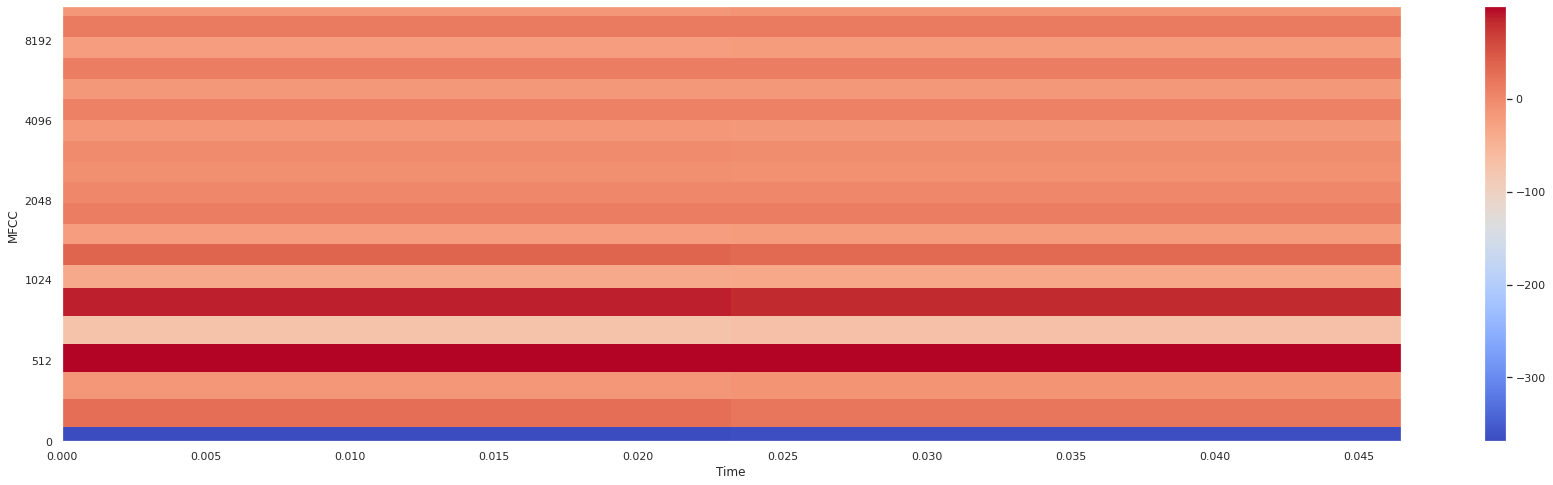

In [372]:
librosa.display.specshow(data[0][740], sr=sample_rate, x_axis='time', y_axis='mel')
plt.ylabel('MFCC')
plt.colorbar()